In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA']   = "1"
from os import path as osp
# if 'jupyter' in os.getcwd():
#     os.chdir(osp.join(os.getcwd(), 'masterarbeit', 'code'))
import glob
import time
import argparse
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmnotebook
import pickle
from pathlib import Path
from typing import Any
from typing import Callable
from typing import Optional
from typing import Tuple
from typing import Union
from typing import Dict
from typing import List
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
mpl.rc('axes', unicode_minus=False)
preamble = r'\usepackage{amsmath}'  # LaTeX preamble command
mpl.rcParams['text.latex.preamble'] = preamble

# import seaborn as sns
import networkx as nx
import math
import numpy as np

import gc

# pytorch imports
import torch
from torch import Tensor, nn, cuda
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.cuda.amp import GradScaler, autocast

# pytorch geometric imports
import torch_geometric
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose

# lightning imports
from lightning.pytorch.utilities.combined_loader import CombinedLoader

from IPython.display import display, clear_output

from google.cloud import storage

import sys
# Add the 'code' directory to sys.path to make the  submodules available
# sys.path.append('/home/jupyter/masterarbeit/code')

from util.utils import generate_log_name
from util.plot_utils import *

import logging as log

from data.dataset.GraphDataset import GraphDataset

from model.transform import CollapseChannels, ExtractSquare
from model.autoencoder import Autoencoder
from model.predictor import Predictor
from model.DAN import GradientReversalLayer, DomainDiscriminator

from model.criterions import WeightedMSELoss, MSLELoss, FocalLoss, ZeroInflatedLoss, CustomHuberLoss

from fullmodel import Model

In [2]:
exp_id='exp09'

In [3]:
NUM_WORKERS: int = 0
BATCH_SIZE: int = 64
NUM_CHANNELS: int = 2
WDW_LENGTH: list = [12, 6]

# Constants that I may change a bit during testing
tgt: str = 'MELBOURNE'
src_list: list = ['ANTWERP']
# src_list: list = ['ANTWERP', 'BANGKOK', 'BARCELONA', 'BERLIN', 'CHICAGO', 'ISTANBUL', 'MOSCOW'] # 7 cities
EPOCHS: int = 2
tgt_data_limit: int = 1680
src_data_limit: int = None
LOGGING: int = 1

if src_data_limit == -1:
    src_data_limit = None

# Get data from bucket
bucket_name = 'cloud-ai-platform-054ad037-69b6-4c4d-94a1-75d2591213c7'
bucket_folder = 'data/graphs'
local_folder  = 'data/graphs'
download_directory(bucket_name, bucket_folder, local_folder)
bucket_folder = 'data/raw'
local_folder  = 'data/raw'
download_directory(bucket_name, bucket_folder, local_folder)

bucket_output = 'output/models/'

# Constants that I don't intend to change much
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_VAL_TEST_SPLIT = [0.8, 0.1, 0.1]

pre_transform = Compose([
    CollapseChannels(),
    ExtractSquare(50, 'central'),
])

static_transform = Compose([
    ExtractSquare(50, 'central'),
])

ds_kwargs = {
    'root_dir': 'data/raw',
    'device': device,
    'pre_transform': pre_transform,
    'static_transform': static_transform,
}

# seed generator for DataLoader
torch.manual_seed(2311)

# Create datasets for each city
ds_dict = {}
for city in src_list:
    ds_dict[city] = GraphDataset(
        cities=[city],
        limit=src_data_limit,
        **ds_kwargs,
    )
    
temp_tgt = GraphDataset(
    cities=[tgt],
    limit=None,
    **ds_kwargs,
)

train_tgt, val_tgt, test_tgt = random_split(
    temp_tgt, [0.08, 0.08, 0.84]
)


train_tgt = DataLoader(train_tgt, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_tgt   = DataLoader(  val_tgt, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
test_tgt  = DataLoader( test_tgt, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
# Split each dataset into training and test sets
train = {}
val   = {}
test  = {}
for city in ds_dict:
    train_ds, val_ds, test_ds = random_split(
        ds_dict[city], TRAIN_VAL_TEST_SPLIT
    )
    train[city] = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
    val[city]   = DataLoader(  val_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
    test[city]  = DataLoader( test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

train[tgt] = train_tgt
val[tgt]   = val_tgt
test[tgt]  = test_tgt

# Create dataloader for offline training with source cities
source_train = {city: train[city] for city in src_list}
source_dataloader = CombinedLoader(source_train, mode='max_size_cycle')

source_test = {city: test[city] for city in src_list}
sourcetest_dataloader = CombinedLoader(source_test, mode='max_size_cycle')

target_dataloader = CombinedLoader({tgt: train[tgt]}, mode='max_size_cycle')
targettest_dataloader = CombinedLoader({tgt: test[tgt]}, mode='max_size_cycle')

# Create dataloader for online training with source and target cities
train_dataloader = CombinedLoader(train, mode='max_size_cycle')

# Create dataloader for validation with source and target cities
val_dataloader = CombinedLoader(val, mode='max_size_cycle')

# Create dataloader for testing with source and target cities
test_dataloader = CombinedLoader(test, mode='max_size_cycle')

Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  50
    Loss: 8353.2324
     Rec:    0.2234
    Disc:    0.1773
Batch:  100
    Loss: 6920.8833
     Rec:    0.1938
    Disc:    0.2885
Batch:  150
    Loss: 6076.0503
     Rec:    0.1545
    Disc:    0.4978
Batch:  200
    Loss: 4925.7681
     Rec:    0.1141
    Disc:    0.4438
    Val Disc: 0.294


/home/jupyter/masterarbeit/code/util/plot_utils.py:184: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


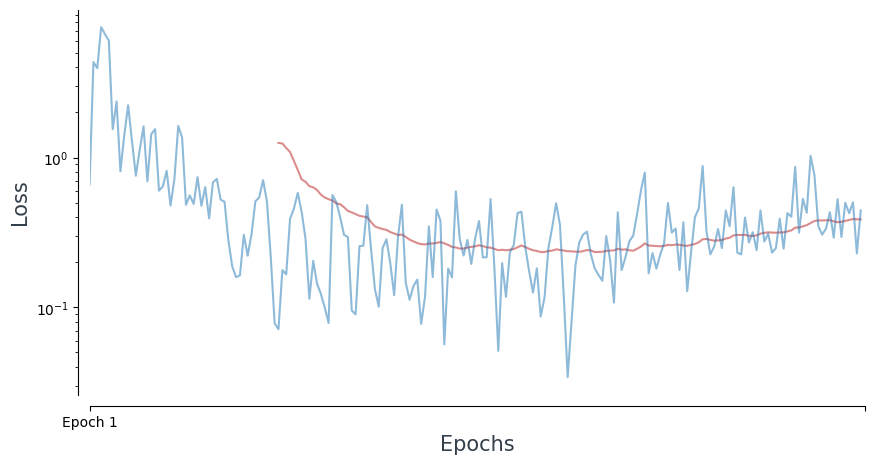

Batch:  250
    Loss: 3685.0303
     Rec:    0.0738
    Disc:    0.2065
Batch:  300
    Loss: 2389.0908
     Rec:    0.0444
    Disc:    0.2729
Batch:  350
    Loss: 2346.2627
     Rec:    0.0267
    Disc:    0.3778
Batch:  400
    Loss: 1757.8345
     Rec:    0.0172
    Disc:    0.4323
    Val Disc: 0.119


<Figure size 640x480 with 0 Axes>

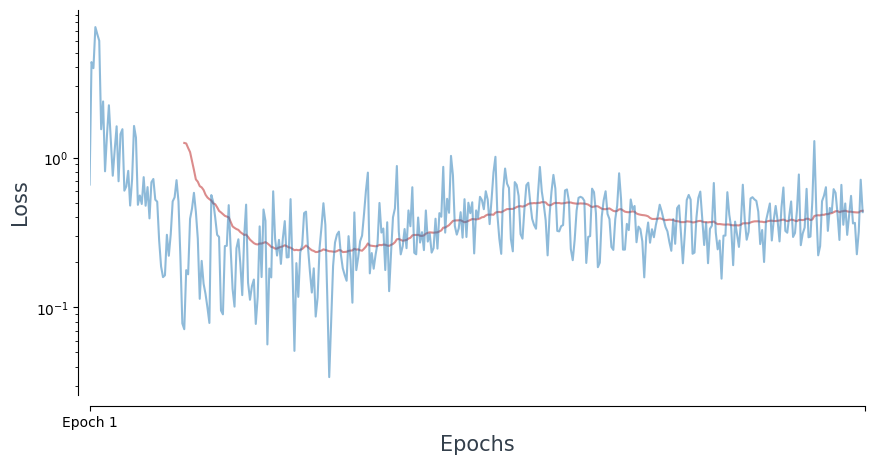

Batch:  450
    Loss: 1892.1964
     Rec:    0.0118
    Disc:    0.3533
Batch:  500
    Loss: 1901.0372
     Rec:    0.0088
    Disc:    0.5093


<Figure size 640x480 with 0 Axes>

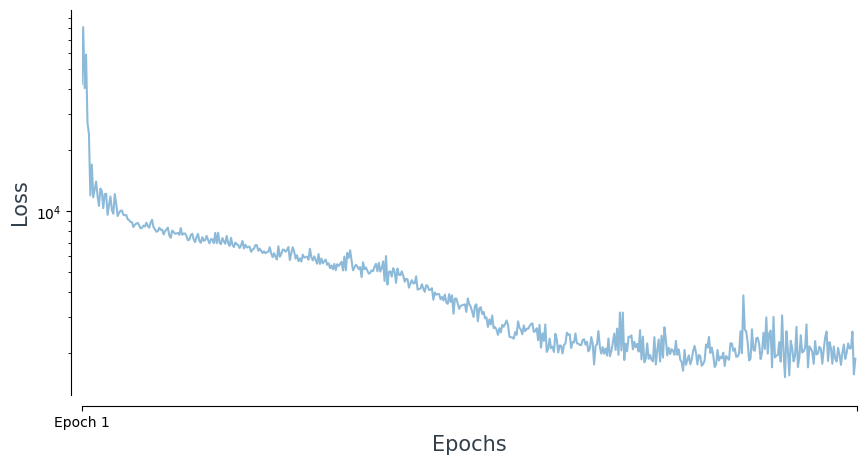

<Figure size 640x480 with 0 Axes>

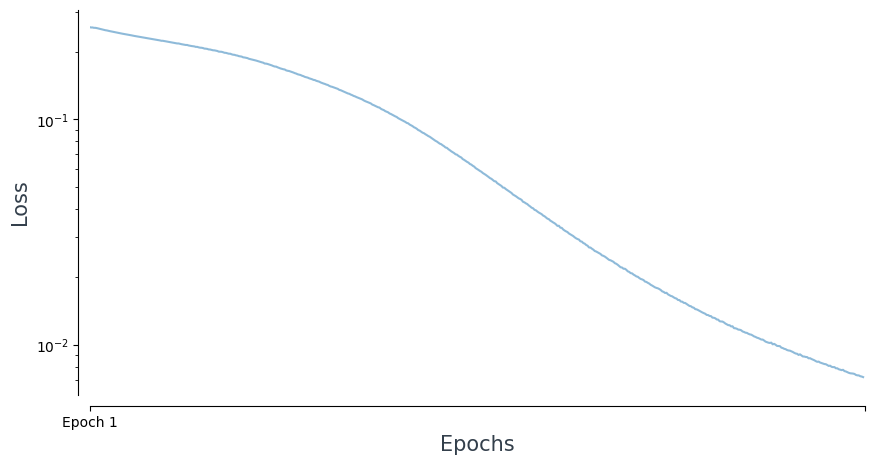

<Figure size 640x480 with 0 Axes>

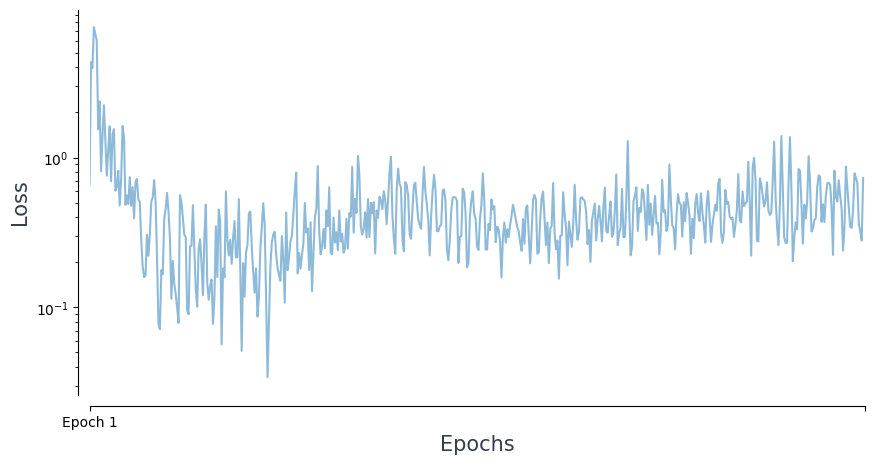

Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  50
    Loss:  324.1078
     Rec:    0.0049
    Disc:    0.0000


Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  0
    Loss: 32217.9141


<Figure size 640x480 with 0 Axes>

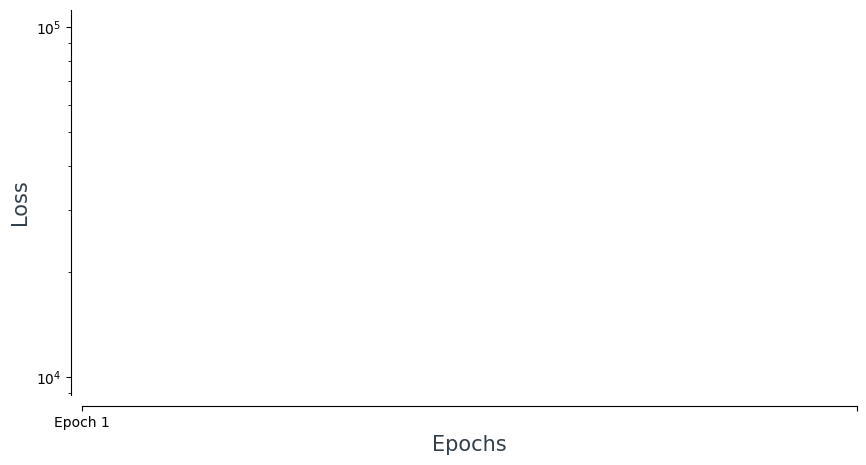

Batch:  50
    Loss: 21902.1055
Batch:  100
    Loss: 10512.8662
Batch:  150
    Loss: 3385.3057
Batch:  200
    Loss: 1275.3354


<Figure size 640x480 with 0 Axes>

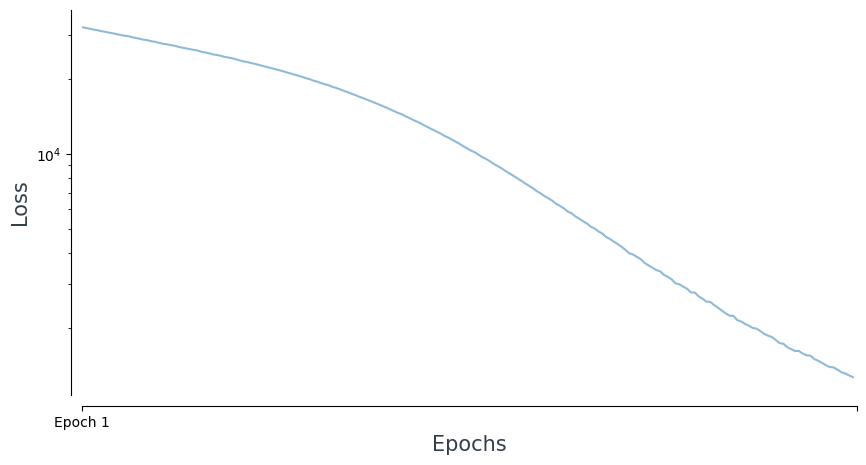

Batch:  250
    Loss:  679.7888
Batch:  300
    Loss:  446.1387
Batch:  350
    Loss:  343.4400
Batch:  400
    Loss:  297.6501


<Figure size 640x480 with 0 Axes>

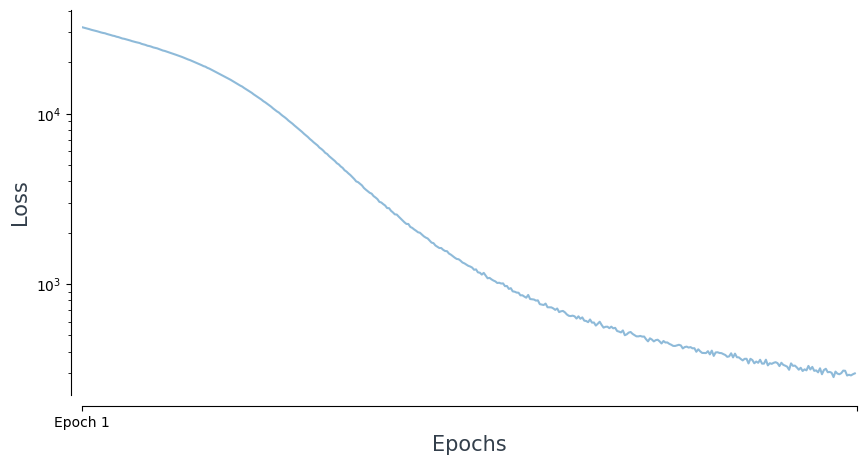

Batch:  450
    Loss:  253.2917
Batch:  500
    Loss:  233.3150


Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  0
    Loss:   76.3177


/home/jupyter/masterarbeit/code/util/plot_utils.py:184: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


<Figure size 640x480 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

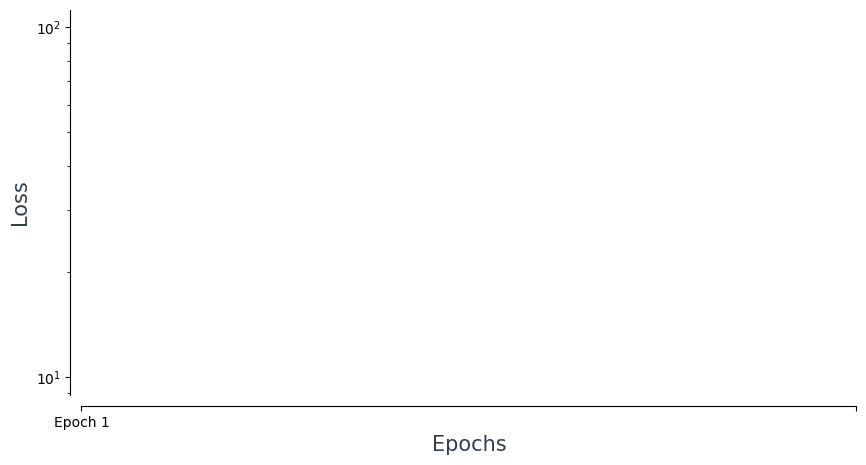

Batch:  50
    Loss:   40.8172


Batches:   0%|          | 0/568 [00:00<?,?it/s]

<Figure size 640x480 with 0 Axes>

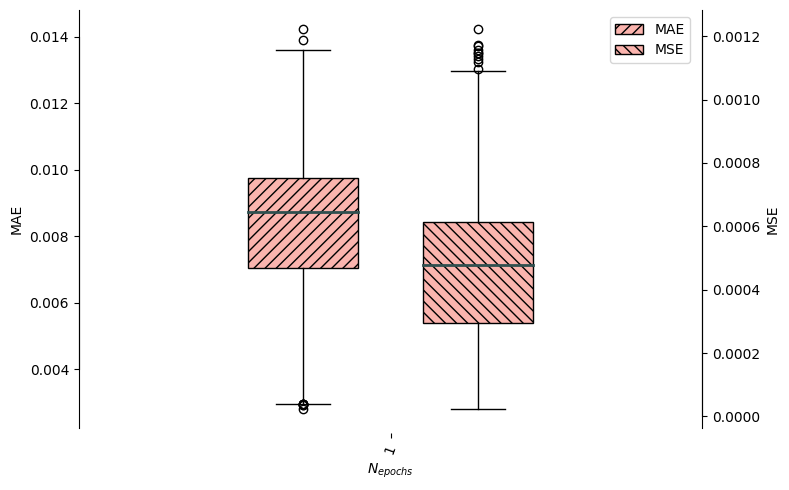

Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  50
    Loss: 7924.0488
     Rec:    0.0036
    Disc:    0.4369
Batch:  100
    Loss: 9682.9727
     Rec:    0.0023
    Disc:    0.3436
Batch:  150
    Loss: 7841.9268
     Rec:    0.0017
    Disc:    0.5030
Batch:  200
    Loss: 9495.8896
     Rec:    0.0013
    Disc:    1.1373
    Val Disc: 0.467


/home/jupyter/masterarbeit/code/util/plot_utils.py:184: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


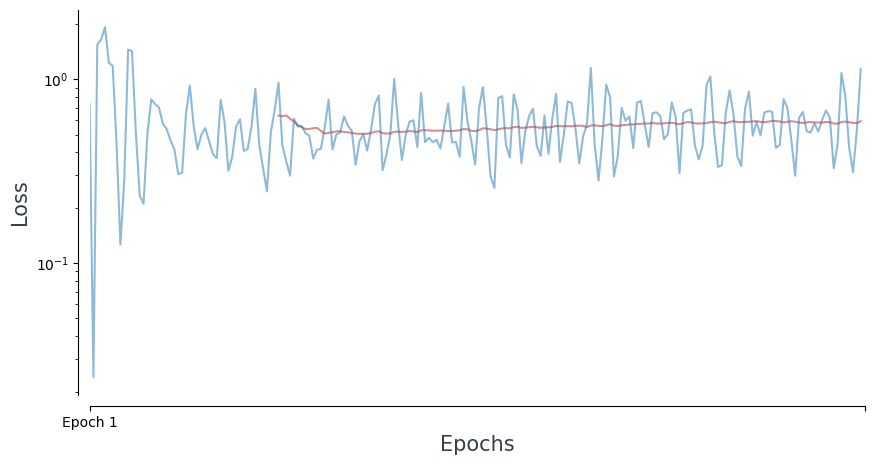

Batch:  250
    Loss: 8582.3750
     Rec:    0.0010
    Disc:    0.6128
Batch:  300
    Loss: 7099.9541
     Rec:    0.0009
    Disc:    0.5588
Batch:  350
    Loss: 7974.0156
     Rec:    0.0008
    Disc:    0.5507
Batch:  400
    Loss: 10149.3330
     Rec:    0.0007
    Disc:    0.7850
    Val Disc: 0.319


<Figure size 640x480 with 0 Axes>

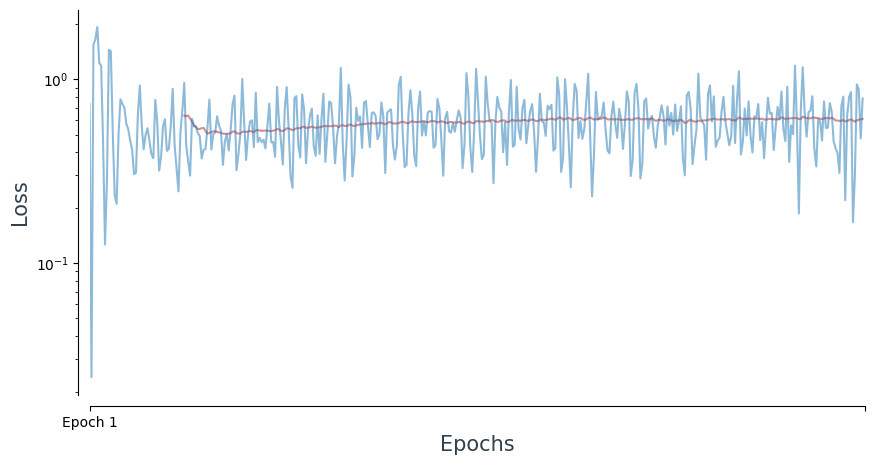

Batch:  450
    Loss: 8187.4092
     Rec:    0.0006
    Disc:    0.7001
Batch:  500
    Loss: 4285.1987
     Rec:    0.0006
    Disc:    0.5130
Batch:  50
    Loss:   37.7377
     Rec:    0.0006
    Disc:    0.0001


Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  0
    Loss:  305.9785


<Figure size 640x480 with 0 Axes>

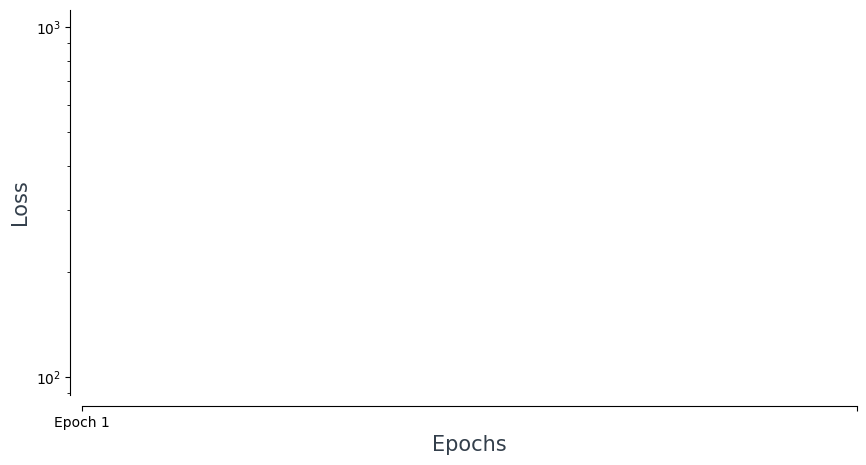

Batch:  50
    Loss:  153.6961
Batch:  100
    Loss:  146.1028
Batch:  150
    Loss:  145.3675
Batch:  200
    Loss:  135.8982


<Figure size 640x480 with 0 Axes>

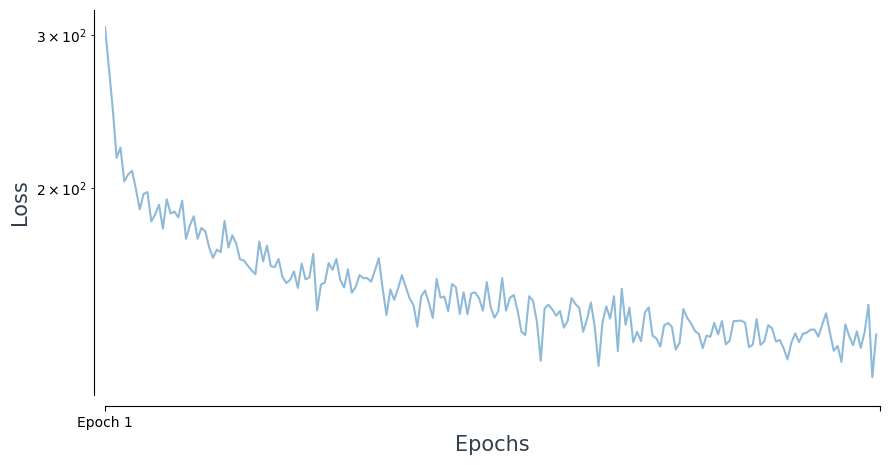

Batch:  250
    Loss:  130.6364
Batch:  300
    Loss:  130.1153
Batch:  350
    Loss:  118.6919
Batch:  400
    Loss:  118.4634


<Figure size 640x480 with 0 Axes>

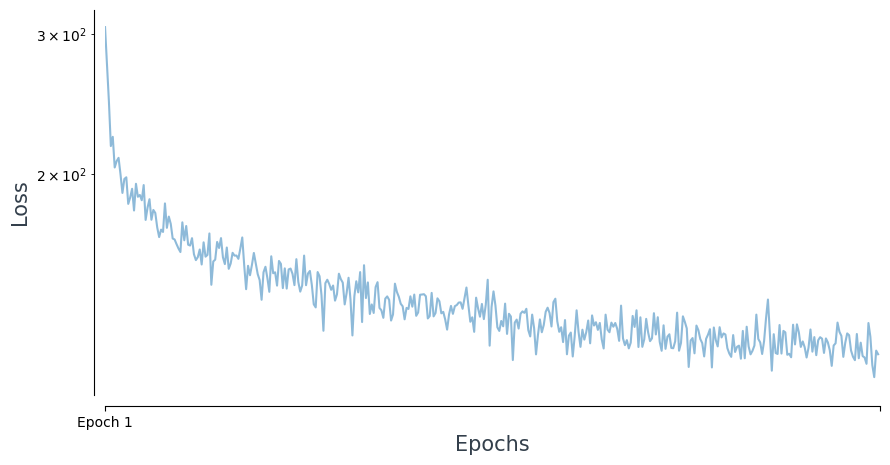

Batch:  450
    Loss:  121.8531
Batch:  500
    Loss:  114.8416


Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  0
    Loss:   31.1371


/home/jupyter/masterarbeit/code/util/plot_utils.py:184: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


<Figure size 640x480 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

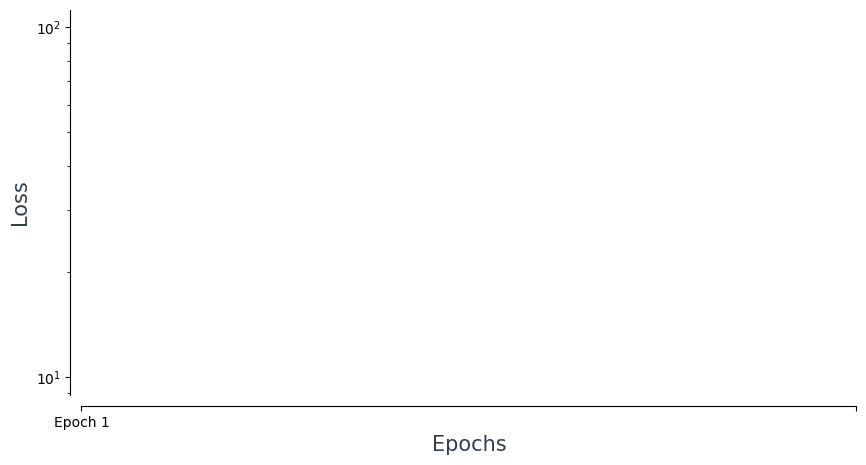

Batch:  50
    Loss:   29.6378


Batches:   0%|          | 0/568 [00:00<?,?it/s]

<Figure size 640x480 with 0 Axes>

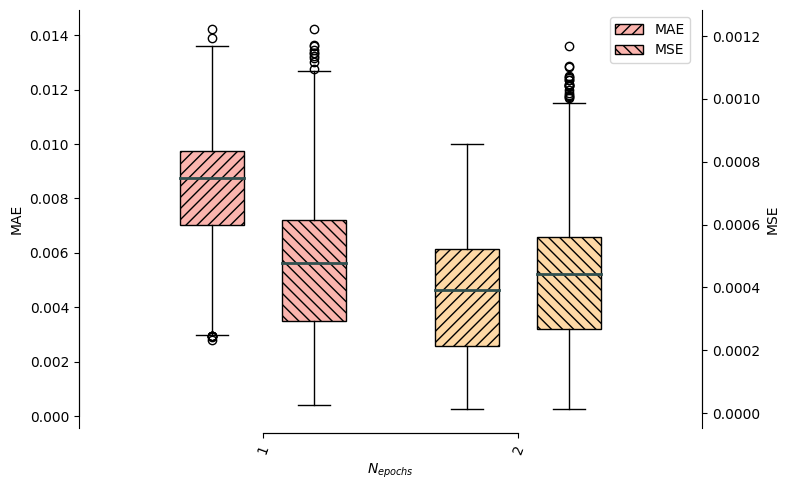

Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  50
    Loss: 3810.1780
     Rec:    0.0005
    Disc:    0.5119
Batch:  100
    Loss: 4227.2651
     Rec:    0.0005
    Disc:    0.7673
Batch:  150
    Loss: 4662.7593
     Rec:    0.0005
    Disc:    0.8743
Batch:  200
    Loss: 4096.5654
     Rec:    0.0005
    Disc:    0.5937
    Val Disc: 0.515


/home/jupyter/masterarbeit/code/util/plot_utils.py:184: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


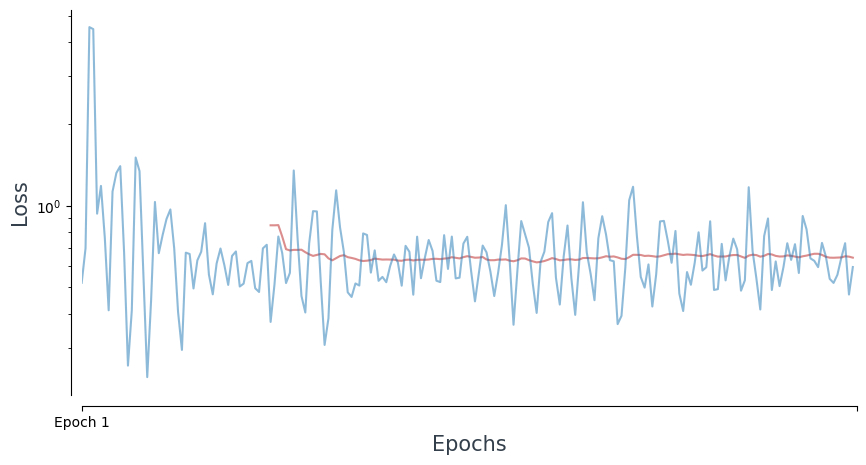

Batch:  250
    Loss: 4252.0410
     Rec:    0.0006
    Disc:    0.7885
Batch:  300
    Loss: 4695.4316
     Rec:    0.0004
    Disc:    0.6313
Batch:  350
    Loss: 4688.6147
     Rec:    0.0005
    Disc:    0.6945
Batch:  400
    Loss: 4865.9595
     Rec:    0.0005
    Disc:    0.9290
    Val Disc: 0.506


<Figure size 640x480 with 0 Axes>

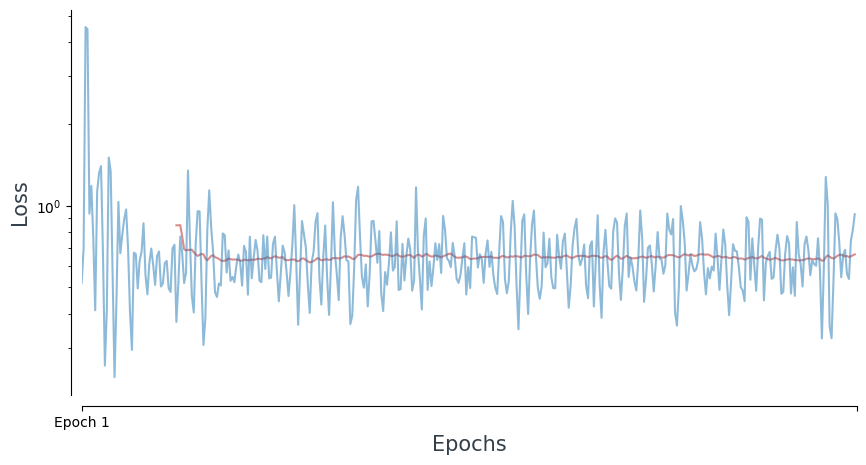

Batch:  450
    Loss: 4244.8750
     Rec:    0.0004
    Disc:    0.4842
Batch:  500
    Loss: 5288.1157
     Rec:    0.0004
    Disc:    1.1376


<Figure size 640x480 with 0 Axes>

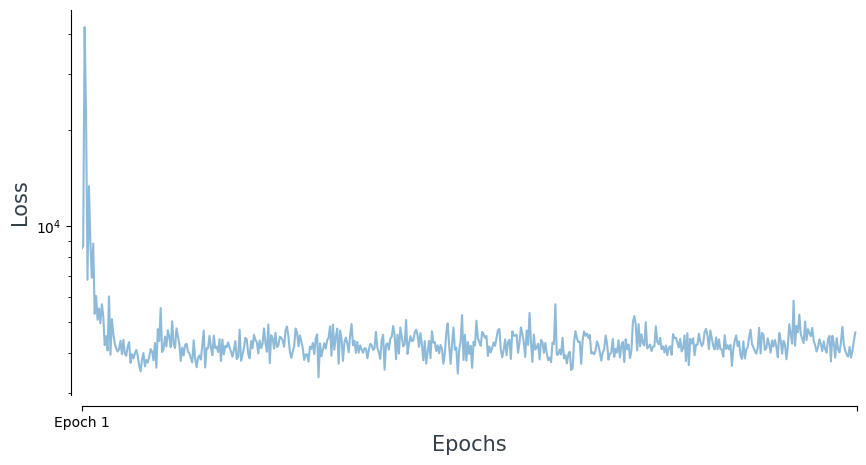

<Figure size 640x480 with 0 Axes>

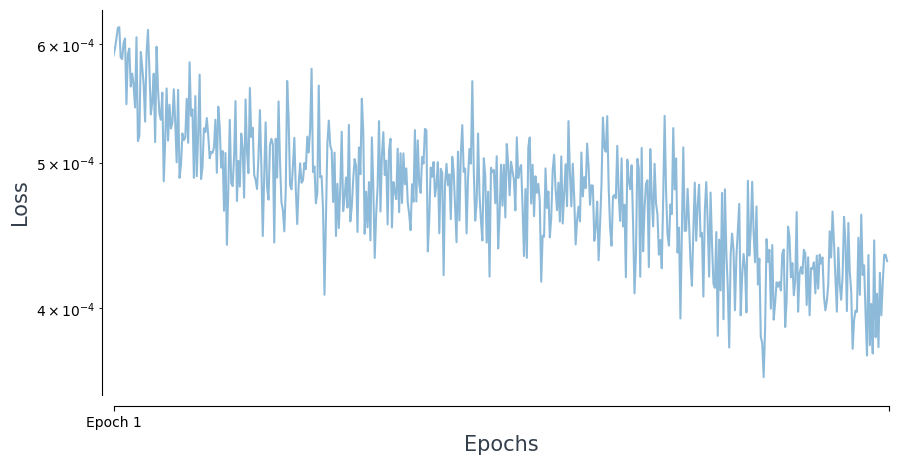

<Figure size 640x480 with 0 Axes>

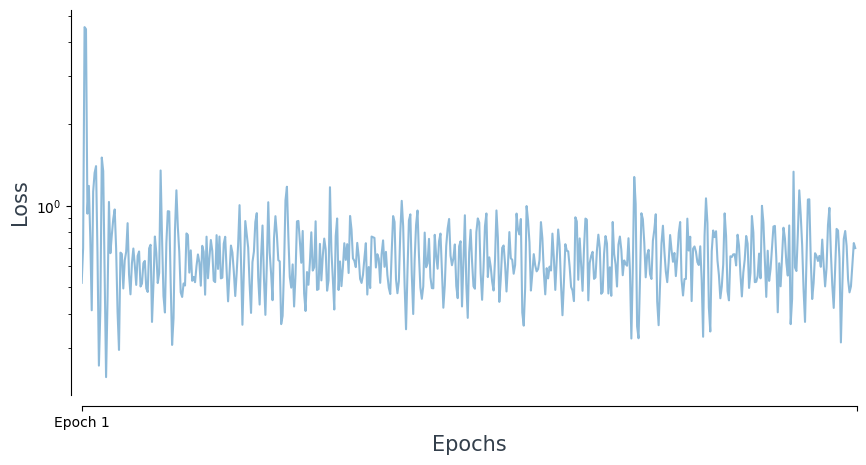

Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  50
    Loss:   11.9484
     Rec:    0.0003
    Disc:    0.0002


Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  0
    Loss:  256.9125


<Figure size 640x480 with 0 Axes>

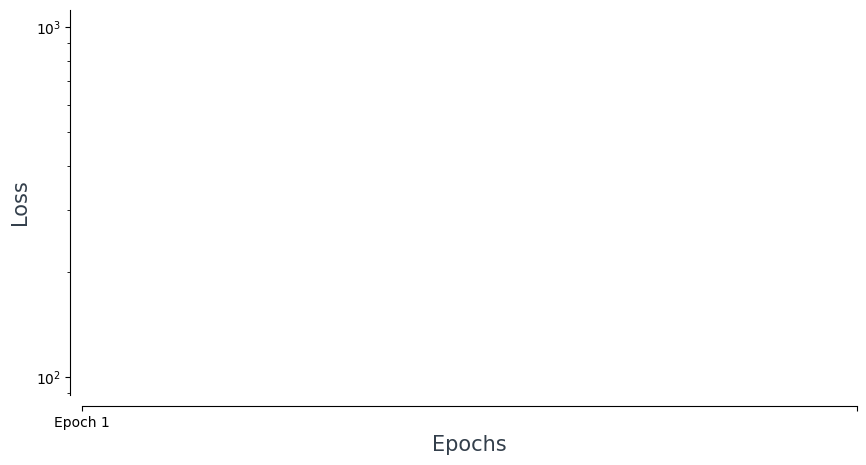

Batch:  50
    Loss:  132.9589
Batch:  100
    Loss:  127.3435
Batch:  150
    Loss:  126.2776
Batch:  200
    Loss:  130.8443


<Figure size 640x480 with 0 Axes>

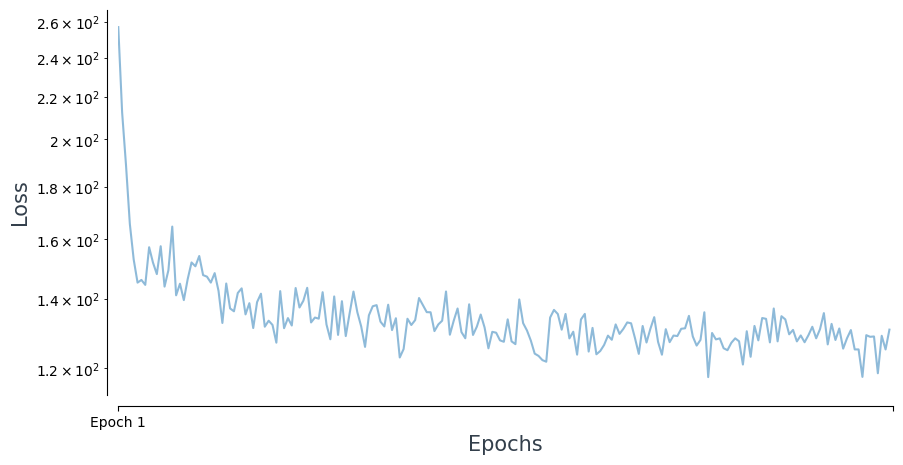

Batch:  250
    Loss:  122.8862
Batch:  300
    Loss:  131.4974
Batch:  350
    Loss:  124.6168
Batch:  400
    Loss:  119.5345


<Figure size 640x480 with 0 Axes>

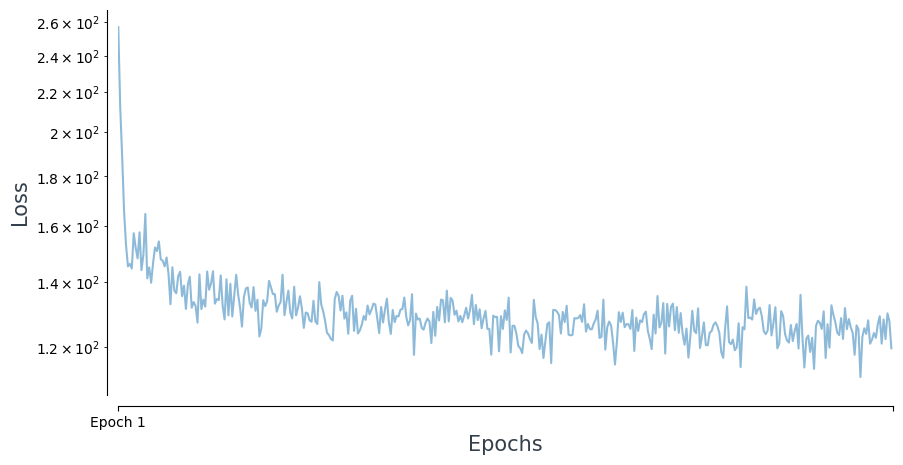

Batch:  450
    Loss:  122.8199
Batch:  500
    Loss:  120.5122


Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  0
    Loss:   30.0485


/home/jupyter/masterarbeit/code/util/plot_utils.py:184: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


<Figure size 640x480 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

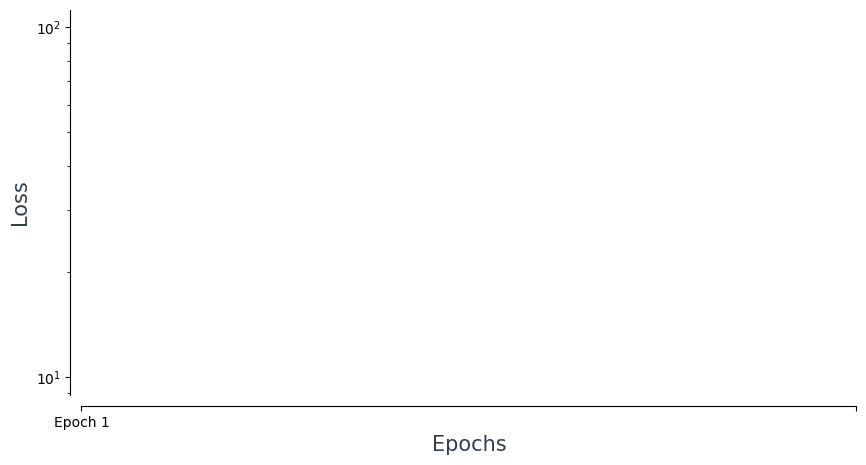

Batch:  50
    Loss:   30.4700


Batches:   0%|          | 0/568 [00:00<?,?it/s]

<Figure size 640x480 with 0 Axes>

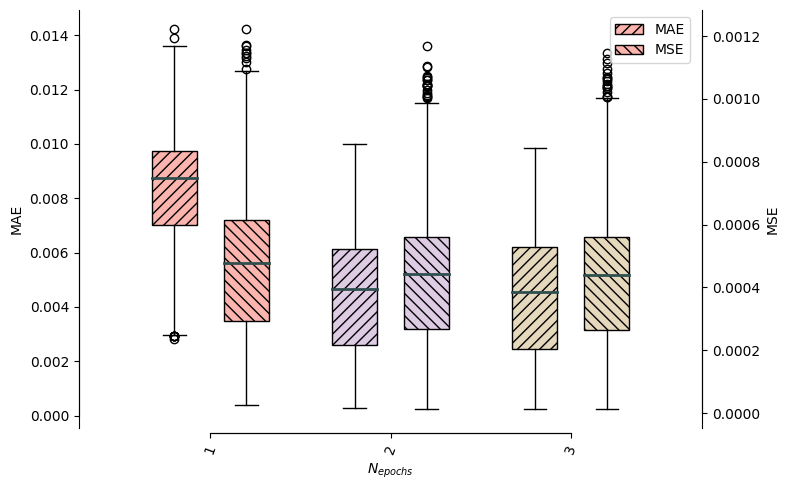

Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  50
    Loss: 2818.5598
     Rec:    0.0004
    Disc:    0.5372
Batch:  100
    Loss: 2083.8037
     Rec:    0.0004
    Disc:    0.6889
Batch:  150
    Loss: 2304.2449
     Rec:    0.0005
    Disc:    0.7055
Batch:  200
    Loss: 1963.8387
     Rec:    0.0004
    Disc:    0.5114
    Val Disc: 0.412


/home/jupyter/masterarbeit/code/util/plot_utils.py:184: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


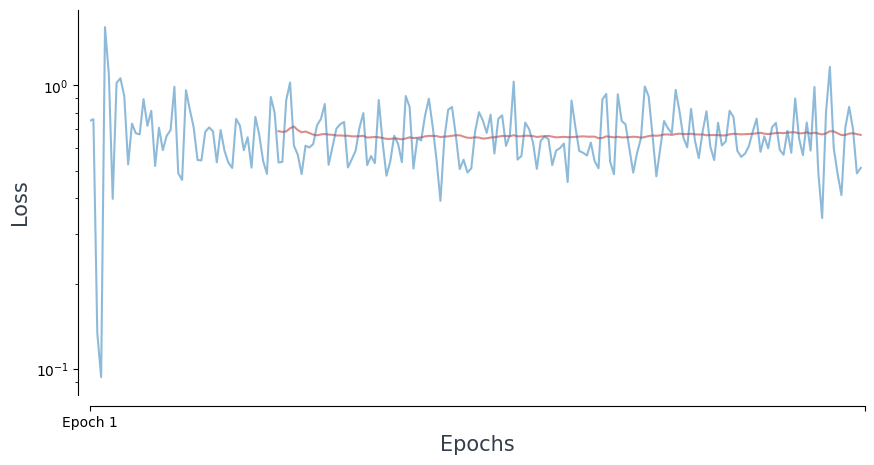

Batch:  250
    Loss: 2220.9875
     Rec:    0.0004
    Disc:    0.6254
Batch:  300
    Loss: 2443.9294
     Rec:    0.0004
    Disc:    0.5273
Batch:  350
    Loss: 2203.1423
     Rec:    0.0004
    Disc:    0.6208
Batch:  400
    Loss: 2296.4680
     Rec:    0.0004
    Disc:    0.8239
    Val Disc: 0.806


<Figure size 640x480 with 0 Axes>

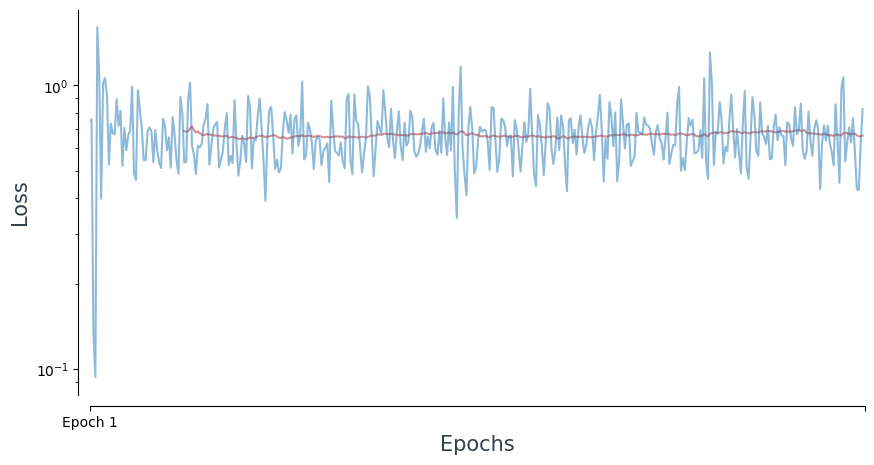

Batch:  450
    Loss: 2430.6155
     Rec:    0.0004
    Disc:    0.9363
Batch:  500
    Loss: 2547.6826
     Rec:    0.0004
    Disc:    0.5164


<Figure size 640x480 with 0 Axes>

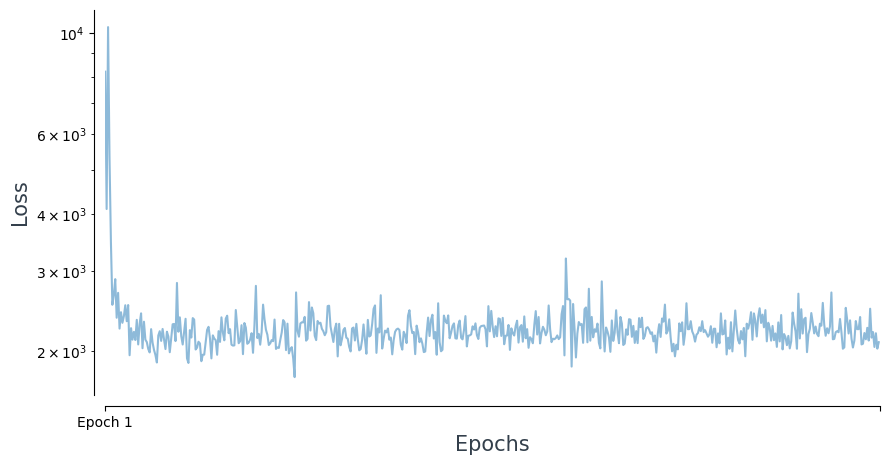

<Figure size 640x480 with 0 Axes>

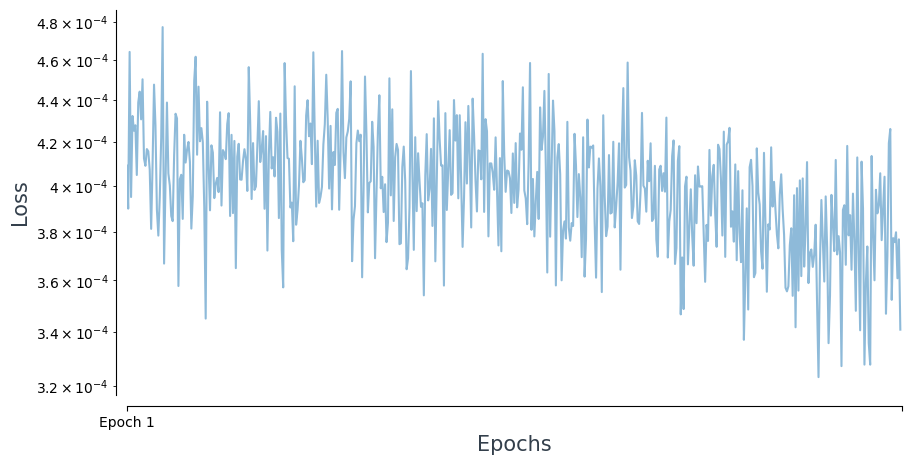

<Figure size 640x480 with 0 Axes>

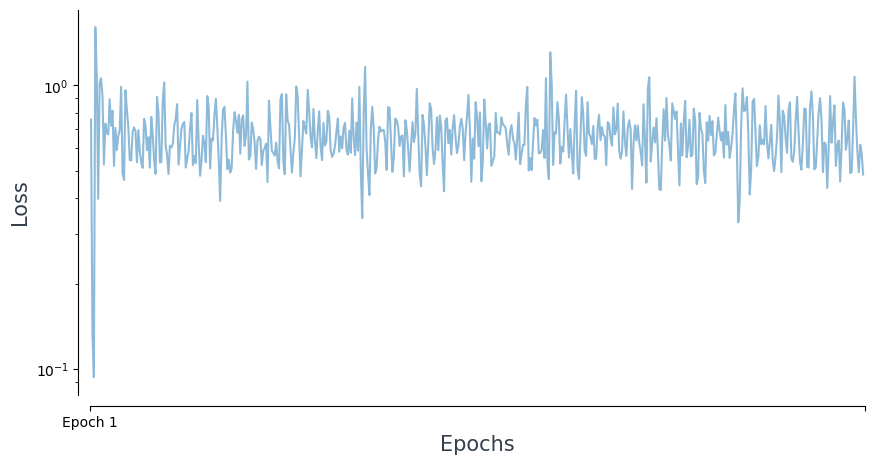

Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  50
    Loss:   12.9250
     Rec:    0.0004
    Disc:    0.0002


Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  0
    Loss:  158.2872


<Figure size 640x480 with 0 Axes>

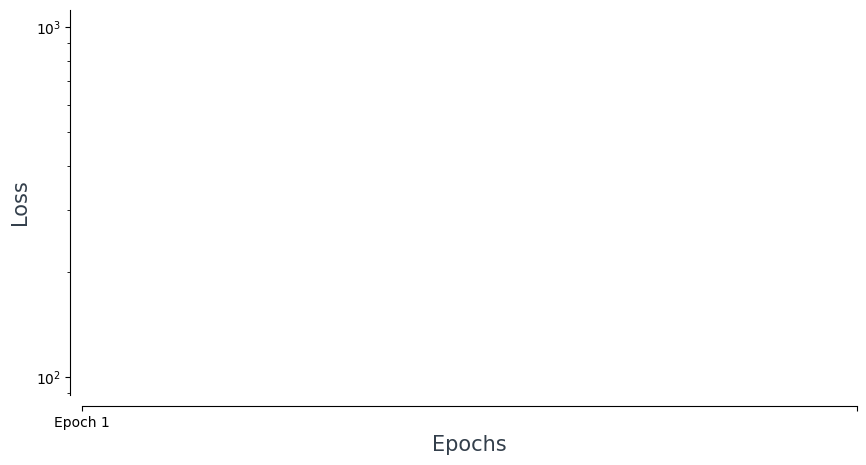

Batch:  50
    Loss:  134.1987
Batch:  100
    Loss:  125.3973
Batch:  150
    Loss:  115.2460
Batch:  200
    Loss:  109.0900


<Figure size 640x480 with 0 Axes>

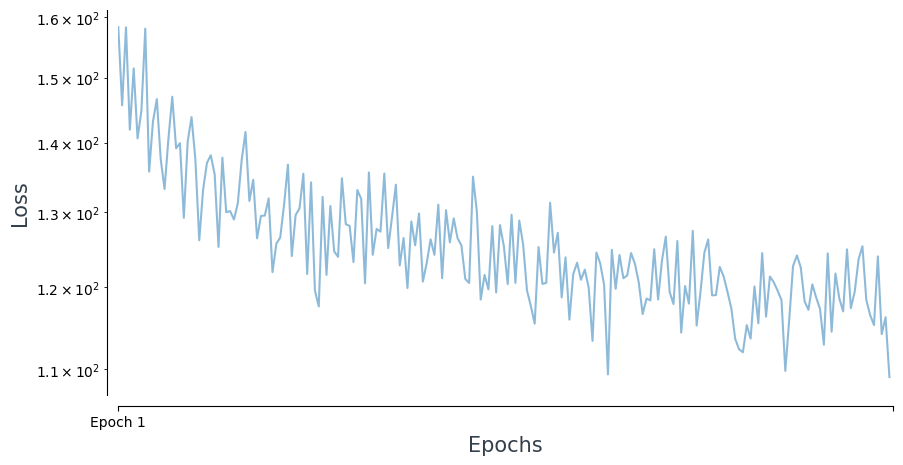

Batch:  250
    Loss:  119.4998
Batch:  300
    Loss:  114.9142
Batch:  350
    Loss:  109.7716
Batch:  400
    Loss:  116.9920


<Figure size 640x480 with 0 Axes>

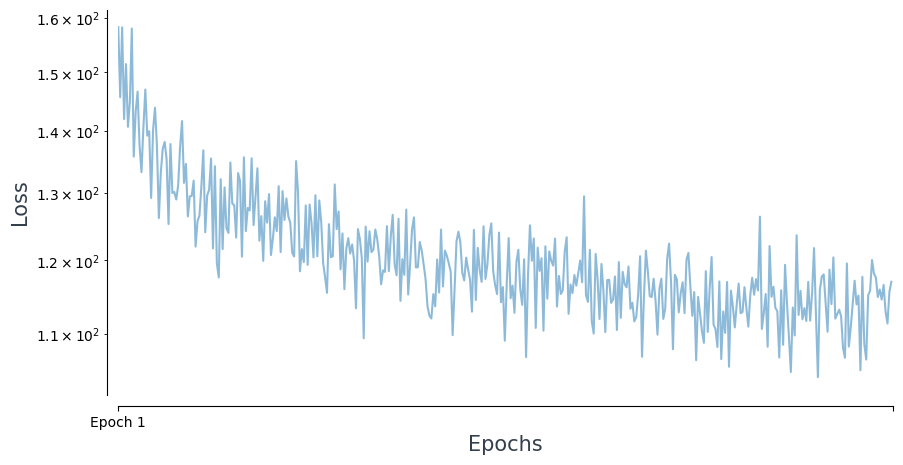

Batch:  450
    Loss:  112.7530
Batch:  500
    Loss:  116.7268


Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  0
    Loss:   27.4375


/home/jupyter/masterarbeit/code/util/plot_utils.py:184: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


<Figure size 640x480 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

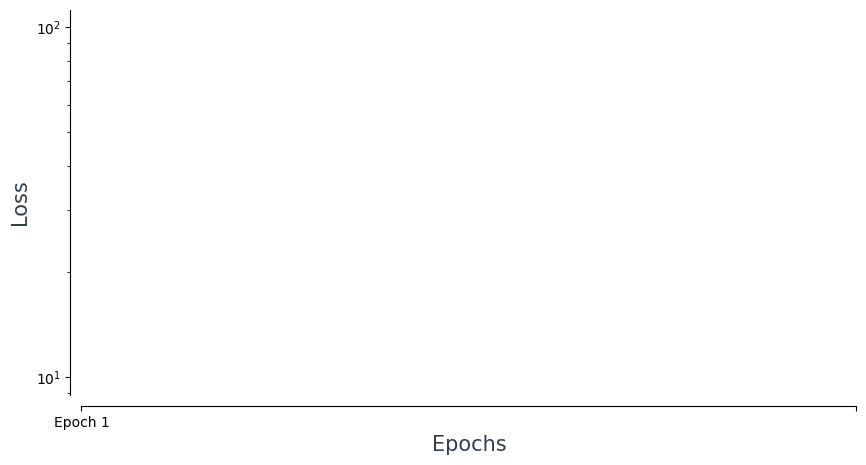

Batch:  50
    Loss:   27.6406


Batches:   0%|          | 0/568 [00:00<?,?it/s]

<Figure size 640x480 with 0 Axes>

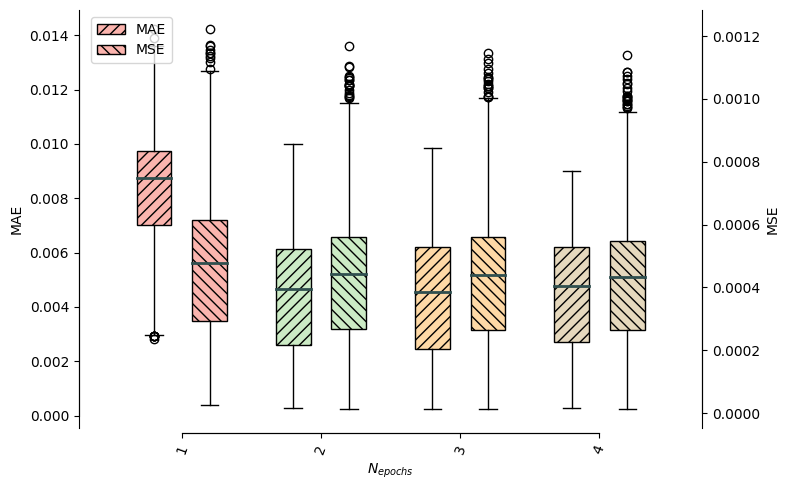

Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  50
    Loss: 2070.6270
     Rec:    0.0003
    Disc:    0.6048
Batch:  100
    Loss: 2417.9866
     Rec:    0.0004
    Disc:    0.8332
Batch:  150
    Loss: 2382.0320
     Rec:    0.0003
    Disc:    0.4406
Batch:  200
    Loss: 2318.4338
     Rec:    0.0004
    Disc:    0.5671
    Val Disc: 0.399


/home/jupyter/masterarbeit/code/util/plot_utils.py:184: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


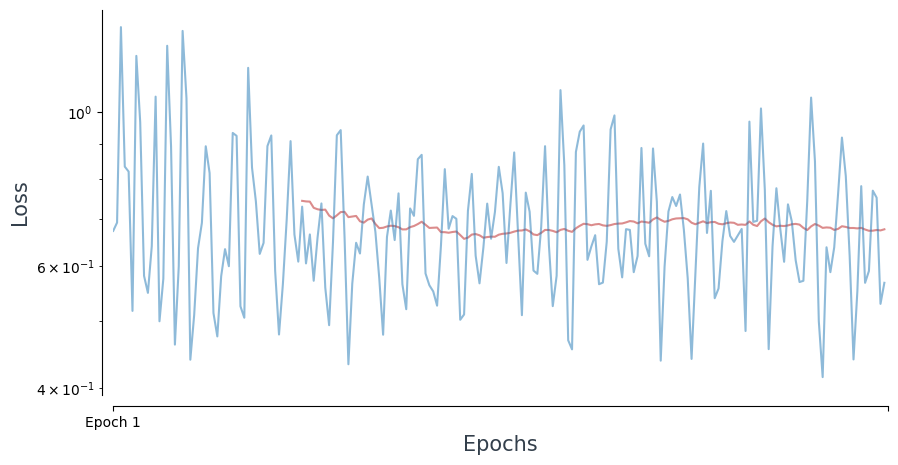

Batch:  250
    Loss: 2204.5701
     Rec:    0.0004
    Disc:    0.7583
Batch:  300
    Loss: 2251.7122
     Rec:    0.0004
    Disc:    0.5308
Batch:  350
    Loss: 2280.2478
     Rec:    0.0004
    Disc:    0.4869
Batch:  400
    Loss: 2052.0906
     Rec:    0.0004
    Disc:    0.5935
    Val Disc: 0.594


<Figure size 640x480 with 0 Axes>

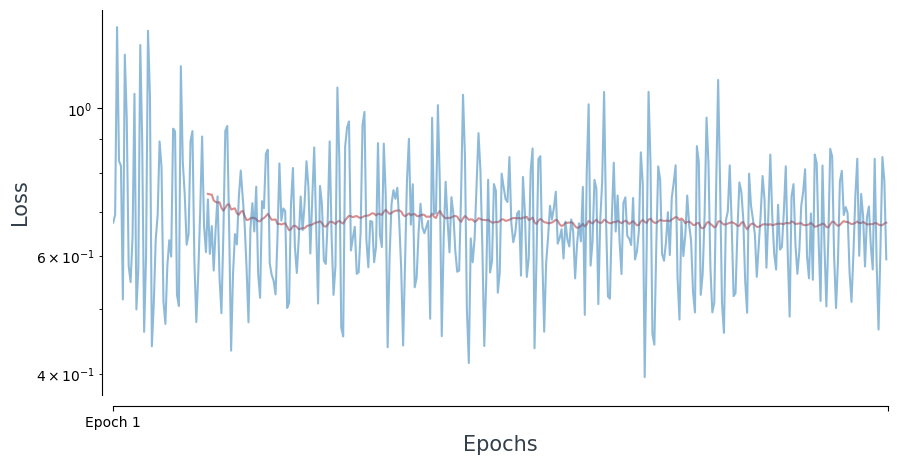

Batch:  450
    Loss: 2307.6165
     Rec:    0.0004
    Disc:    0.6178
Batch:  500
    Loss: 2234.3389
     Rec:    0.0004
    Disc:    0.7419


<Figure size 640x480 with 0 Axes>

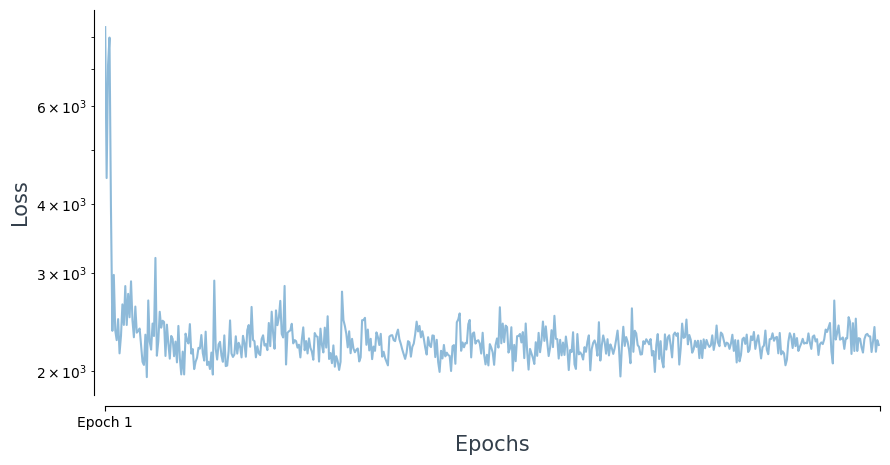

<Figure size 640x480 with 0 Axes>

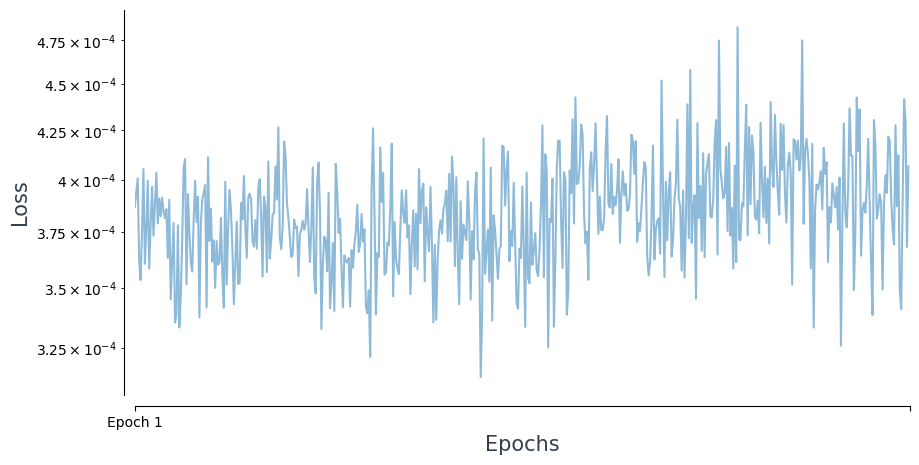

<Figure size 640x480 with 0 Axes>

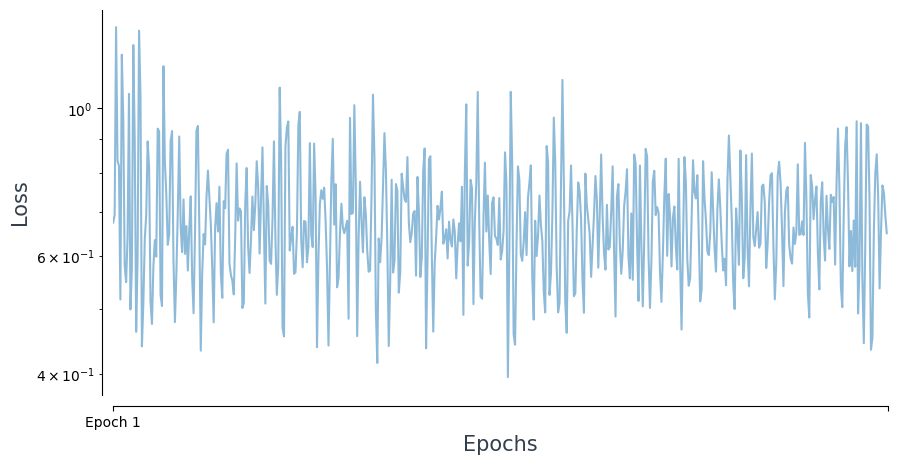

Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/55 [00:00<?,?it/s]

Batch:  50
    Loss:   16.7328
     Rec:    0.0004
    Disc:    0.0013


Epochs:   0%|          | 0/1 [00:00<?,?it/s]

Batches:   0%|          | 0/541 [00:00<?,?it/s]

Batch:  0
    Loss:  174.4574


<Figure size 640x480 with 0 Axes>

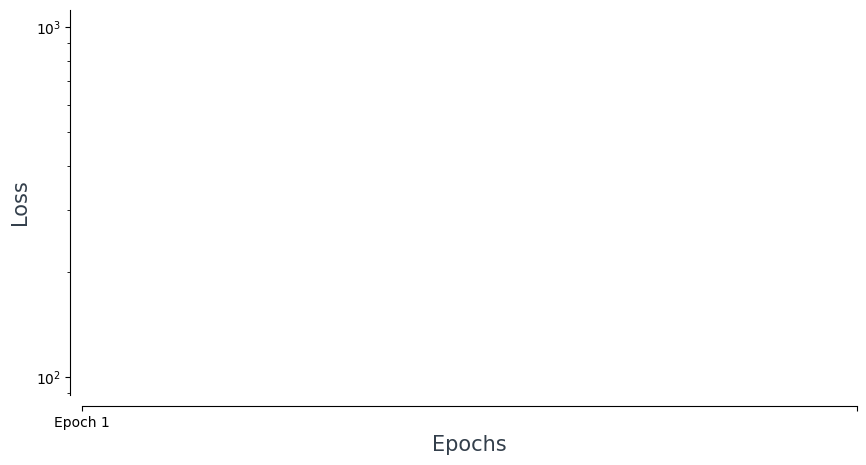

Batch:  50
    Loss:  132.3150
Batch:  100
    Loss:  122.5931


In [ ]:
##############################################################################
########################## INSTANTIATING THE MODEL ###########################
##############################################################################
AE_K_CHEB = 3
AE_CONV_DIM = 16
AE_LINEAR_DIM = 8
AE_DROPOUT = 0.5
AE_ACTIVATION = 'tanh'

AE_parameters = {
    'K_cheb': AE_K_CHEB,
    'conv_dim': AE_CONV_DIM,
    'linear_dim': AE_LINEAR_DIM,
    'dropout': AE_DROPOUT,
    'activation': AE_ACTIVATION,
    'num_channels': NUM_CHANNELS,
    'device': device,
}

DD_SEQ_LEN = 12
DD_FEAT_DIM = AE_LINEAR_DIM
DD_LEFT_NODES = 1750
DD_parameters = {
    'seq_len': DD_SEQ_LEN,
    'feat_dim': DD_FEAT_DIM,
    'left_nodes': DD_LEFT_NODES,
}

# autoencoder linear dims + 4 sin-cos time features
PRED_FEATURES   = AE_LINEAR_DIM + 4
PRED_LINEAR_DIM = 32
PRED_PERIODS_IN = 12
PRED_PERIODS_OUT = [0, 1, 2, 5, 8, 11]
PRED_ACTIVATION  = 'relu'

PR_parameters = {
    'features': PRED_FEATURES,
    'linear_dim': PRED_LINEAR_DIM,
    'periods_in': PRED_PERIODS_IN,
    'periods_out': PRED_PERIODS_OUT,
    'activation': PRED_ACTIVATION,
    'num_channels': NUM_CHANNELS,
    'device': device,
    'batch_size': BATCH_SIZE,
    
}
num_epochs = EPOCHS
dataloaders = train_dataloader, target_dataloader, targettest_dataloader
AE_criterion = nn.MSELoss()
PR_criterion = nn.MSELoss()
optimizer_parameters = 5e-4, 5e-5
BATCH_SIZE = BATCH_SIZE
dd_lambda = 0.1

folder = osp.join('training logs', 'models', exp_id)
check_dir(folder)
test_errors = {}

l_num_epochs = [1, 2, 3, 4, 5]

for num_epochs in l_num_epochs:
    model = Model(
        AE_parameters=AE_parameters,
        DD_parameters=DD_parameters,
        PR_parameters=PR_parameters,
        num_epochs=1,
        dataloaders=dataloaders,
        AE_criterion=AE_criterion,
        PR_criterion=PR_criterion,
        optimizer_parameters=optimizer_parameters,
        BATCH_SIZE=BATCH_SIZE,
        dd_lambda=dd_lambda,
        folder=folder,
        specs=f'{num_epochs}',
        tgt=tgt,
        val_dl=val_dataloader
    ).to(device)
    if num_epochs > 1:
        model.load_module('autoencoder', model.folder, f'ae_pretrain_{num_epochs - 1}.pth')
        model.load_module('discriminator', model.folder, f'dd_pretrain_{num_epochs - 1}.pth')
        model.load_module('predictor', model.folder, f'pred_pretrain_{num_epochs - 1}.pth')
    
    model.ae_train('pretrain', save=False, lambda_update=1.5, plot=1)
    
    if num_epochs < 5:
        model.save_module('autoencoder', model.folder, f'ae_pretrain_{num_epochs}.pth')
        model.save_module('discriminator', model.folder, f'dd_pretrain_{num_epochs}.pth')
    
    model.ae_train('finetune', save=True)

    model.pred_train('pretrain', save=False, plot=1)
    
    if num_epochs < 5:
        model.save_module('predictor', model.folder, f'pred_pretrain_{num_epochs}.pth')
    
    model.pred_train('finetune', save=True)
    
    errors = model.pred_test()
    test_errors[num_epochs] = errors
    plot_losses_boxplot(
        test_errors, 
        r'$N_{epochs}$', 
        save=False, 
        exp_id=exp_id,
    )

plot_losses_boxplot(
    test_errors, 
    r'$N_{epochs}$', 
    save=True,
    exp_id=exp_id,
)
